In [1]:
%load_ext autoreload
%autoreload 2

# Run this code cell to set notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95%; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import cv2
import copy
import glob
import json
import torch
import string
import random
import mlflow
import numpy as np
import torchmetrics
import pandas as pd
import networkx as nx
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from easydict import EasyDict
from datetime import datetime
from dateutil.parser import parse
from sklearn.manifold import TSNE
from difflib import SequenceMatcher
from torch.optim.lr_scheduler import CyclicLR
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

random.seed(42)

In [3]:
DATA_DIR = "../data/interim/2022-01-06_combined_orc_kyc"
DATA_KEY_DIR = "../data/interim/2022-01-06_combined_orc_kyc-key-fields"
DATA_VALUE_DIR = "../data/interim/2022-01-21_KTP_value_field"
TRAIN_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_TRAIN"
VAL_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_VAL"
TEST_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_TEST"
ANNOTATION_FILE = f"{DATA_DIR}/ktp_ground_truth.csv"
KTP_VALUE_FIELD_CLASS_FILE = f"{DATA_VALUE_DIR}/classes.txt"
RESIZE=(512, 256)
TEST_SPLIT = 0.1
VAL_SPLIT = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
LOG_PATH = '../logs'
VERBOSE = True
MODEL_DIR = '../runs'
MODEL_SAVED_PATH = '../runs/models'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open(KTP_VALUE_FIELD_CLASS_FILE) as f:
    lines = f.readlines()
classes = [item.strip() for item in lines]
ind_to_classes_mapping = {str(i): val for i, val in enumerate(classes)}
classes_to_ind_mapping = {val: key for key, val in ind_to_classes_mapping.items()}
print(f'Classes -> {classes}\nTotal number of classes = {len(classes)}')
print(f'Index to class mapping ->\n{ind_to_classes_mapping}')
print(f'Class to index mapping ->\n{classes_to_ind_mapping}')

Classes -> ['TEXT', 'NIK', 'NAMA', 'Tempat', 'Jenis Kelamin', 'Alamat', 'RT/RW', 'Kel/Desa', 'Kecamantan', 'Agama', 'Pekerjaan', 'Berlaku Hingga', 'Kewarganegaraan', 'Nama', 'Tgl Lahir', 'Status Perkawinan', 'Kota', 'NIk']
Total number of classes = 18
Index to class mapping ->
{'0': 'TEXT', '1': 'NIK', '2': 'NAMA', '3': 'Tempat', '4': 'Jenis Kelamin', '5': 'Alamat', '6': 'RT/RW', '7': 'Kel/Desa', '8': 'Kecamantan', '9': 'Agama', '10': 'Pekerjaan', '11': 'Berlaku Hingga', '12': 'Kewarganegaraan', '13': 'Nama', '14': 'Tgl Lahir', '15': 'Status Perkawinan', '16': 'Kota', '17': 'NIk'}
Class to index mapping ->
{'TEXT': '0', 'NIK': '1', 'NAMA': '2', 'Tempat': '3', 'Jenis Kelamin': '4', 'Alamat': '5', 'RT/RW': '6', 'Kel/Desa': '7', 'Kecamantan': '8', 'Agama': '9', 'Pekerjaan': '10', 'Berlaku Hingga': '11', 'Kewarganegaraan': '12', 'Nama': '13', 'Tgl Lahir': '14', 'Status Perkawinan': '15', 'Kota': '16', 'NIk': '17'}


In [5]:
def clean_data(path, txt_path):
    key_field_files = os.listdir(path)
    data_keys = []
    for ind, key_field_file in tqdm(enumerate(key_field_files)):
        try:
            if '.jpg' in key_field_file or '.jpeg' in key_field_file or '.png' in key_field_file or '.webp' in key_field_file:
                file_name = key_field_file.split('.')[0]
                with open(os.path.join(txt_path, file_name+'.txt')) as f:
                    lines = f.readlines()
                yolo_bbox = [item.strip() for item in lines]
                with open(os.path.join(txt_path, file_name+'.json')) as json_file:
                    data = json.load(json_file)
                image_width = data['fullTextAnnotation']['pages'][0]['width']
                image_height = data['fullTextAnnotation']['pages'][0]['height']
                x_diff, y_diff = 0, 0
                n_image_width, n_image_height = 0, 0
                for i in range(len(yolo_bbox)):
                    # Value without cropping
                    xmin = min(data['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'], data['textAnnotations'][i]['boundingPoly']['vertices'][3]['x'])
                    xmax = max(data['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'], data['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'])
                    ymin = min(data['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'], data['textAnnotations'][i]['boundingPoly']['vertices'][1]['y'])
                    ymax = max(data['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'], data['textAnnotations'][i]['boundingPoly']['vertices'][3]['y'])
                    data['textAnnotations'][i]['cx'], data['textAnnotations'][i]['cy'] = (xmax + xmin) // 2, (ymax + ymin) // 2
                    # Value with cropping | google vision api
                    if i == 0:
                        x_diff, y_diff = xmin, ymin
                        n_image_width = xmax - xmin
                        n_image_height = ymax - ymin
                    top_left = (data['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'] - y_diff)
                    top_right = (data['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][1]['y'] - y_diff)
                    bottom_right = (data['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'] - y_diff)
                    bottom_left = (data['textAnnotations'][i]['boundingPoly']['vertices'][3]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][3]['y'] - y_diff)
                    data['textAnnotations'][i]['boundingPoly']['normalized_vertices'] = [
                        {'x': x, 'y': y} for x, y in [top_left, top_right, bottom_right, bottom_left]
                    ]
                    n_xmin = min(top_left[0], bottom_left[0])
                    n_xmax = max(top_right[0], bottom_right[0])
                    n_ymin = min(top_left[1], top_right[1])
                    n_ymax = max(bottom_right[1], bottom_left[1])
                    data['textAnnotations'][i]['n_cx'], data['textAnnotations'][i]['n_cy'] = (n_xmax + n_xmin) // 2, (n_ymax + n_ymin) // 2
                    data['textAnnotations'][i]['class_index'] = yolo_bbox[i].split()[0]
                    data['textAnnotations'][i]['class'] = ind_to_classes_mapping[yolo_bbox[i].split()[0]]
                    if yolo_bbox[i].split()[0] == '0':
                        data['textAnnotations'][i]['is_key'] = False
                    else:
                        data['textAnnotations'][i]['is_key'] = True
                data_keys.append(
                    {   
                        'file_name': file_name,
                        'image_name': key_field_file,
                        'file_path': os.path.join(path, key_field_file),
                        'image_width': image_width,
                        'image_height': image_height,
                        'normalized_image_width': n_image_width,
                        'normalized_image_height': n_image_height,
                        'data': data['textAnnotations']
                    }
                )
        except Exception as e:
            continue
    return data_keys

train_data = clean_data(TRAIN_DATA_KTP_KEY_FIELD_DIR, DATA_VALUE_DIR)
val_data = clean_data(VAL_DATA_KTP_KEY_FIELD_DIR, DATA_VALUE_DIR)
test_data = clean_data(TEST_DATA_KTP_KEY_FIELD_DIR, DATA_VALUE_DIR)

284it [00:00, 901.22it/s] 
39it [00:00, 980.88it/s]
75it [00:00, 464.45it/s]


In [6]:
train_data[0]

{'file_name': '202106100907_0a',
 'image_name': '202106100907_0a.jpg',
 'file_path': '../data/interim/2022-01-06_combined_orc_kyc-key-fields/KTP_TRAIN/202106100907_0a.jpg',
 'image_width': 664,
 'image_height': 418,
 'normalized_image_width': 565,
 'normalized_image_height': 327,
 'data': [{'locale': 'id',
   'description': 'PROVS IAl\nKABUPAT BE Gis.\nKI\nNama\n:SYAFRIZAL\nTempit/igl Labie ADANG RIMO, e\nILAKI (AKI\nL TECAL BAR\n1002 0\nAl JAMDAN\nMANDAU\nBLAM\net Osral O\nAmat\nSta\nPelajn\nWRARVAST\nBENOKALIS\nBerlaku Hingga d-11-2017\n',
   'boundingPoly': {'vertices': [{'x': 34, 'y': 20},
     {'x': 599, 'y': 20},
     {'x': 599, 'y': 347},
     {'x': 34, 'y': 347}],
    'normalized_vertices': [{'x': 0, 'y': 0},
     {'x': 565, 'y': 0},
     {'x': 565, 'y': 327},
     {'x': 0, 'y': 327}]},
   'cx': 316,
   'cy': 183,
   'n_cx': 282,
   'n_cy': 163,
   'class_index': '0',
   'class': 'TEXT',
   'is_key': False},
  {'description': 'PROVS',
   'boundingPoly': {'vertices': [{'x': 251,

Text(0.5, 1.0, 'Clipped image')

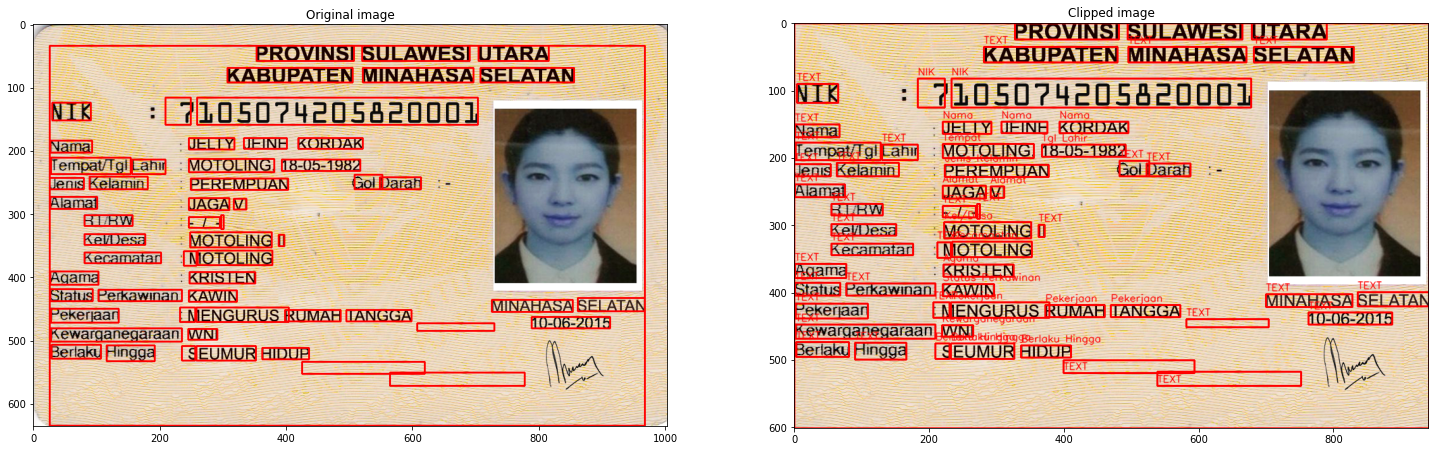

In [7]:
ind = random.randint(0, len(train_data)-1)
image = cv2.imread(train_data[ind]['file_path'])
image_copy = copy.deepcopy(image[
    train_data[ind]['data'][0]['boundingPoly']['vertices'][0]['y']
    :
    train_data[ind]['data'][0]['boundingPoly']['vertices'][2]['y'],
    train_data[ind]['data'][0]['boundingPoly']['vertices'][0]['x']
    :
    train_data[ind]['data'][0]['boundingPoly']['vertices'][2]['x'],
    :
])
for key in train_data[ind]['data']:
    image = cv2.rectangle(image, (key['boundingPoly']['vertices'][0]['x'], key['boundingPoly']['vertices'][0]['y']), (key['boundingPoly']['vertices'][2]['x'], key['boundingPoly']['vertices'][2]['y']), (255, 0, 0), 2)
    image_copy = cv2.rectangle(image_copy, (key['boundingPoly']['normalized_vertices'][0]['x'], key['boundingPoly']['normalized_vertices'][0]['y']), (key['boundingPoly']['normalized_vertices'][2]['x'], key['boundingPoly']['normalized_vertices'][2]['y']), (255, 0, 0), 2)
    image_copy = cv2.putText(image_copy, key['class'], (key['boundingPoly']['normalized_vertices'][0]['x'], key['boundingPoly']['normalized_vertices'][0]['y']-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,25))
ax1.imshow(image)
ax1.set_title("Original image")
ax2.imshow(image_copy)
ax2.set_title("Clipped image")

In [8]:
def resize_point(image_width, image_height, point, size=RESIZE):
    new_w, new_h = size
    ratio_w = new_w / image_width
    ratio_h = new_h / image_height
    return (point[0] * ratio_w, point[1] * ratio_h)

def get_df(raw_data):
    data_list = []
    for ind, data in tqdm(enumerate(raw_data)):
        for i, item in enumerate(data['data']):
            is_first = 0
            if i == 0:
                is_first = 1
            doc_xmin, doc_ymin = data['data'][0]['boundingPoly']['vertices'][0]['x'], data['data'][0]['boundingPoly']['vertices'][0]['y']
            doc_xmax, doc_ymax = data['data'][0]['boundingPoly']['vertices'][2]['x'], data['data'][0]['boundingPoly']['vertices'][2]['y']
            center_coords = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['n_cx'], item['n_cy']))
            x1, y1 = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['boundingPoly']['normalized_vertices'][0]['x'], item['boundingPoly']['normalized_vertices'][0]['y']))
            x2, y2 = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['boundingPoly']['normalized_vertices'][1]['x'], item['boundingPoly']['normalized_vertices'][1]['y']))
            x3, y3 = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['boundingPoly']['normalized_vertices'][2]['x'], item['boundingPoly']['normalized_vertices'][2]['y']))
            x4, y4 = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['boundingPoly']['normalized_vertices'][3]['x'], item['boundingPoly']['normalized_vertices'][3]['y']))
            base_data = [
                    data['file_name'],
                    data['image_name'],
                    data['file_path'],
                    item['description'],
                ]
            derived_data = [
                    doc_xmin, doc_ymin, doc_xmax, doc_ymax,
                    center_coords[0],
                    center_coords[1],
                    x1, y1, x2, y2, x3, y3, x4, y4,
                    center_coords[0]/RESIZE[0], 
                    center_coords[1]/RESIZE[1],
                    x1/RESIZE[0], y1/RESIZE[1], x2/RESIZE[0], y2/RESIZE[1], x3/RESIZE[0], y3/RESIZE[1], x4/RESIZE[0], y4/RESIZE[1],
                    data['normalized_image_width'],
                    data['normalized_image_height'],
                    RESIZE[0],
                    RESIZE[1]
            ]
            labels = [
                is_first,
                int(item['is_key']),
                int(item['class_index']),
                ind_to_classes_mapping[item['class_index']]
            ]
            data_list.append(
                base_data + derived_data + labels
            )
    return pd.DataFrame(data_list, columns=
                        ['file_name', 'image_name', 'file_path', 'text']
                      + ['doc_xmin', 'doc_ymin', 'doc_xmax', 'doc_ymax', 'cx', 'cy', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'n_cx', 'n_cy', 'n_x1', 'n_y1', 'n_x2', 'n_y2', 'n_x3', 'n_y3', 'n_x4', 'n_y4', 'n_image_width', 'n_image_height', 'resize_width', 'resize_height']
                      + ['is_first', 'is_key', 'raw_label', 'raw_label_name']
                    )

train_df = get_df(train_data)
train_df['is_val'] = 0
train_df['is_test'] = 0
val_df = get_df(val_data)
val_df['is_val'] = 1
val_df['is_test'] = 0
test_df = get_df(test_data)
test_df['is_val'] = 0
test_df['is_test'] = 1
df = pd.concat([train_df, val_df, test_df])
df

82it [00:00, 4372.68it/s]
12it [00:00, 4531.52it/s]
22it [00:00, 4112.80it/s]


,file_name,image_name,file_path,text,doc_xmin,doc_ymin,doc_xmax,doc_ymax,cx,cy,...,n_image_width,n_image_height,resize_width,resize_height,is_first,is_key,raw_label,raw_label_name,is_val,is_test
0,202106100907_0a,202106100907_0a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,PROVS IAl\nKABUPAT BE Gis.\nKI\nNama\n:SYAFRIZ...,34,20,599,347,255.546903,127.608563,...,565,327,512,256,1,0,0,TEXT,0,0
1,202106100907_0a,202106100907_0a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,PROVS,34,20,599,347,251.015929,9.394495,...,565,327,512,256,0,0,0,TEXT,0,0
2,202106100907_0a,202106100907_0a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,IAl,34,20,599,347,338.010619,10.960245,...,565,327,512,256,0,0,0,TEXT,0,0
3,202106100907_0a,202106100907_0a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,KABUPAT,34,20,599,347,221.111504,28.183486,...,565,327,512,256,0,0,0,TEXT,0,0
4,202106100907_0a,202106100907_0a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,BE,34,20,599,347,304.481416,28.966361,...,565,327,512,256,0,0,0,TEXT,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,Copy_STNK_&_KTP_21,Copy_STNK_&_KTP_21.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,SEUMUR,8,33,589,363,167.435456,248.242424,...,581,330,512,256,0,0,0,TEXT,0,1
1071,Copy_STNK_&_KTP_21,Copy_STNK_&_KTP_21.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,HIDUP,8,33,589,363,222.953528,250.569697,...,581,330,512,256,0,0,0,TEXT,0,1
1072,Copy_STNK_&_KTP_21,Copy_STNK_&_KTP_21.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,KOTA,8,33,589,363,437.094664,219.539394,...,581,330,512,256,0,0,0,TEXT,0,1
1073,Copy_STNK_&_KTP_21,Copy_STNK_&_KTP_21.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,MALANG,8,33,589,363,485.562823,221.866667,...,581,330,512,256,0,0,0,TEXT,0,1


In [9]:
df['file_name'].nunique()

116

In [10]:
df = df[~((df['image_name'] == '202106100904_0.jpg') | (df['image_name'] == '202106100904_16.jpg')| (df['image_name'] == 'STNK9.jpeg')) ] #stnk
df = df[~(df['image_name'].str.contains('denoising') | (df['image_name'] == 'All_KYC_Docs_50.jpg'))] #blurry docs
df = df[~(df['image_name'] == '202106100907_0a.jpg')]
#manual inspection removing invalid ones 
df = df[~(df['image_name'].isin(['202106100909_2.jpg', '202106100912_12a.jpg', '202106100918_0a.jpg', 
                 '202106100918_4.jpg', '202106100918_9a.jpg', '202106100923_1a.jpg', 
                 '202106100924_0.jpg', '202106100924_3a.jpg', '202106100925_0.jpg', 
                 'All_KYC_Docs_105b.jpg', 'All_KYC_Docs_122b.jpg', 'All_KYC_Docs_127a.jpg', 
                 'All_KYC_Docs_127.jpg', 'All_KYC_Docs_130.jpg', 'All_KYC_Docs_14b.jpg', 
                 'All_KYC_Docs_151.jpg', 'All_KYC_Docs_156b.jpg', 'All_KYC_Docs_171.jpg', 
                 'All_KYC_Docs_182.jpg', 'All_KYC_Docs_185a.jpg', 'All_KYC_Docs_194a.jpg', 
                 'All_KYC_Docs_45a.jpg', 'All_KYC_Docs_45.jpg', 'All_KYC_Docs_58a.jpg', 
                 'All_KYC_Docs_90b.jpg', 'All_KYC_Docs_99c.jpg', 'Copy_STNK_&_KTP_10.jpg', 
                 'Copy_STNK_&_KTP_19a.jpg', 'Copy_STNK_&_KTP_2a.jpg', 'Copy_STNK_&_KTP_4b.jpg', 
                 'Copy_STNK_&_KTP_6a.jpg', 'Copy_STNK_&_KTP_6.jpg']))]
print(df['file_name'].nunique())
print(df.columns)
df

52
Index(['file_name', 'image_name', 'file_path', 'text', 'doc_xmin', 'doc_ymin',
       'doc_xmax', 'doc_ymax', 'cx', 'cy', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3',
       'x4', 'y4', 'n_cx', 'n_cy', 'n_x1', 'n_y1', 'n_x2', 'n_y2', 'n_x3',
       'n_y3', 'n_x4', 'n_y4', 'n_image_width', 'n_image_height',
       'resize_width', 'resize_height', 'is_first', 'is_key', 'raw_label',
       'raw_label_name', 'is_val', 'is_test'],
      dtype='object')


,file_name,image_name,file_path,text,doc_xmin,doc_ymin,doc_xmax,doc_ymax,cx,cy,...,n_image_width,n_image_height,resize_width,resize_height,is_first,is_key,raw_label,raw_label_name,is_val,is_test
36,202106100907_13a,202106100907_13a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,PROVINSI KEPULAUAN RIAU\nКОТА ВАТАМ\n: 2171060...,21,38,988,665,255.735264,127.795853,...,967,627,512,256,1,0,0,TEXT,0,0
37,202106100907_13a,202106100907_13a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,PROVINSI,21,38,988,665,199.081696,5.716108,...,967,627,512,256,0,0,0,TEXT,0,0
38,202106100907_13a,202106100907_13a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,KEPULAUAN,21,38,988,665,299.152017,6.532695,...,967,627,512,256,0,0,0,TEXT,0,0
39,202106100907_13a,202106100907_13a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,RIAU,21,38,988,665,377.513961,7.349282,...,967,627,512,256,0,0,0,TEXT,0,0
40,202106100907_13a,202106100907_13a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,КОТА,21,38,988,665,255.735264,20.822967,...,967,627,512,256,0,0,0,TEXT,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,Copy_STNK_&_KTP_21,Copy_STNK_&_KTP_21.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,SEUMUR,8,33,589,363,167.435456,248.242424,...,581,330,512,256,0,0,0,TEXT,0,1
1071,Copy_STNK_&_KTP_21,Copy_STNK_&_KTP_21.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,HIDUP,8,33,589,363,222.953528,250.569697,...,581,330,512,256,0,0,0,TEXT,0,1
1072,Copy_STNK_&_KTP_21,Copy_STNK_&_KTP_21.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,KOTA,8,33,589,363,437.094664,219.539394,...,581,330,512,256,0,0,0,TEXT,0,1
1073,Copy_STNK_&_KTP_21,Copy_STNK_&_KTP_21.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,MALANG,8,33,589,363,485.562823,221.866667,...,581,330,512,256,0,0,0,TEXT,0,1


In [11]:
df['file_name'].unique()

array(['202106100907_13a', '202106100907_5', '202106100918_12',
       'All_KYC_Docs_115', 'All_KYC_Docs_15a', 'All_KYC_Docs_80a', 'KTP2',
       'All_KYC_Docs_115a', 'All_KYC_Docs_117b', 'All_KYC_Docs_120a',
       'All_KYC_Docs_133', 'All_KYC_Docs_146', 'All_KYC_Docs_97a',
       'Copy_STNK_&_KTP_0c', 'KTP3', 'KTP4', 'KTP5', 'KTP6', 'KTP7',
       'KTP8', 'KTP9', 'KTP12', 'KTP14', 'KTP15', 'KTP16', 'KTP17',
       'KTP18', 'KTP19', 'KTP31', '202106100925_14', '202106100925_3',
       'KTP29', 'KTP34', 'KTP35', 'KTP36', 'KTP37', 'KTP38', 'KTP39',
       '202106100924_0a', 'KTP27', 'KTP28', 'KTP30', 'KTP33', 'KTP40',
       'KTP41', 'KTP20', 'KTP21', 'KTP22', 'KTP24', 'KTP25',
       'All_KYC_Docs_190', 'Copy_STNK_&_KTP_21'], dtype=object)

In [12]:
df['text_cleaned'] = df['text'].apply(lambda x: re.sub(r"[^A-Za-z0-9\-]+", ' ', str(x)))
df[['text', 'text_cleaned', 'raw_label']]

,text,text_cleaned,raw_label
36,PROVINSI KEPULAUAN RIAU\nКОТА ВАТАМ\n: 2171060...,PROVINSI KEPULAUAN RIAU 2171060103890002 NIK N...,0
37,PROVINSI,PROVINSI,0
38,KEPULAUAN,KEPULAUAN,0
39,RIAU,RIAU,0
40,КОТА,,0
...,...,...,...
1070,SEUMUR,SEUMUR,0
1071,HIDUP,HIDUP,0
1072,KOTA,KOTA,0
1073,MALANG,MALANG,0


In [13]:
df.iloc[4]['text'] == df.iloc[-3]['text']

False

In [14]:
[ord(c) for c in df.iloc[4]['text']] 

[1050, 1054, 1058, 1040]

In [15]:
[ord(c) for c in df.iloc[-3]['text']] 

[75, 79, 84, 65]

In [16]:
df['label_name'] = df['raw_label_name'].apply(lambda x: x.upper())

In [17]:
df['label_name'].unique()

array(['TEXT', 'NIK', 'RT/RW', 'TEMPAT', 'KEL/DESA', 'KECAMANTAN',
       'AGAMA', 'PEKERJAAN', 'BERLAKU HINGGA', 'KEWARGANEGARAAN', 'NAMA',
       'TGL LAHIR', 'STATUS PERKAWINAN', 'KOTA', 'JENIS KELAMIN',
       'ALAMAT'], dtype=object)

In [18]:
label_to_ind = {i: str(ind) for ind, i in enumerate(df['label_name'].unique().tolist())}
ind_to_label = {v: k for k, v in label_to_ind.items()}

In [19]:
df['label'] = df['label_name'].apply(lambda x: int(label_to_ind[x]))
df[['text', 'text_cleaned', 'label_name', 'label']]

,text,text_cleaned,label_name,label
36,PROVINSI KEPULAUAN RIAU\nКОТА ВАТАМ\n: 2171060...,PROVINSI KEPULAUAN RIAU 2171060103890002 NIK N...,TEXT,0
37,PROVINSI,PROVINSI,TEXT,0
38,KEPULAUAN,KEPULAUAN,TEXT,0
39,RIAU,RIAU,TEXT,0
40,КОТА,,TEXT,0
...,...,...,...,...
1070,SEUMUR,SEUMUR,TEXT,0
1071,HIDUP,HIDUP,TEXT,0
1072,KOTA,KOTA,TEXT,0
1073,MALANG,MALANG,TEXT,0


In [20]:
df[df['label_name'] == 'NAMA']

,file_name,image_name,file_path,text,doc_xmin,doc_ymin,doc_xmax,doc_ymax,cx,cy,...,resize_height,is_first,is_key,raw_label,raw_label_name,is_val,is_test,text_cleaned,label_name,label
61,202106100907_13a,202106100907_13a.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,BUDHA,21,38,988,665,163.607032,158.826156,...,256,0,1,13,Nama,0,0,BUDHA,NAMA,10
170,202106100918_12,202106100918_12.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,YUSUF,38,60,1230,716,170.953020,78.048780,...,256,0,1,13,Nama,0,0,YUSUF,NAMA,10
171,202106100918_12,202106100918_12.jpg,../data/interim/2022-01-06_combined_orc_kyc-ke...,MONO,38,60,1230,716,221.208054,79.609756,...,256,0,1,13,Nama,0,0,MONO,NAMA,10
749,KTP2,KTP2.jpeg,../data/interim/2022-01-06_combined_orc_kyc-ke...,RUMONDANG,36,45,631,448,173.821849,63.523573,...,256,0,1,13,Nama,0,0,RUMONDANG,NAMA,10
750,KTP2,KTP2.jpeg,../data/interim/2022-01-06_combined_orc_kyc-ke...,BULAN,36,45,631,448,248.685714,64.158809,...,256,0,1,13,Nama,0,0,BULAN,NAMA,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,KTP22,KTP22.jpeg,../data/interim/2022-01-06_combined_orc_kyc-ke...,JULIANA,11,13,427,246,148.923077,78.008584,...,256,0,1,13,Nama,0,1,JULIANA,NAMA,10
830,KTP24,KTP24.jpeg,../data/interim/2022-01-06_combined_orc_kyc-ke...,:DARYANA,13,14,367,253,173.559322,64.267782,...,256,0,1,13,Nama,0,1,DARYANA,NAMA,10
856,KTP25,KTP25.jpeg,../data/interim/2022-01-06_combined_orc_kyc-ke...,N.,12,22,675,483,155.993967,61.639913,...,256,0,1,13,Nama,0,1,N,NAMA,10
857,KTP25,KTP25.jpeg,../data/interim/2022-01-06_combined_orc_kyc-ke...,ALAM,12,22,675,483,186.111614,61.639913,...,256,0,1,13,Nama,0,1,ALAM,NAMA,10


In [21]:
def process_df(df):
    df_res = pd.DataFrame()
    sentences, embeddings, tags = [], [], []
    for file_name in df['file_name'].unique():
        temp_df = df[df['file_name'] == file_name]
        sentence = temp_df[temp_df['is_first'] == 1].iloc[0]['text_cleaned']
        tag = ''
        embedding = []
        for ind, row in temp_df.iterrows():
            if row['text_cleaned'] != sentence:
                length = len(row['text_cleaned'].strip().split())
                if length == 0:
                    continue
                tag += f"{str(row['label'])} " * length
                emb = [row['cx'], row['cy'], row['x1'], row['y1'], row['x2'], row['y2'], row['x3'], row['y3'], row['x4'], row['y4']]
                for i in range(length):
                    embedding.append(emb)
        temp_df['tag'] = tag
        df_res = pd.concat([df_res, temp_df])
        sentences.append((sentence, row['is_val'], row['is_test']))
        tags.append((tag, row['is_val'], row['is_test']))
        embeddings.append((np.asarray(embedding).T, row['is_val'], row['is_test']))
    return sentences, embeddings, tags, df_res

sentences, embeddings, tags, processed_df = process_df(df)               

In [22]:
ce_weights = np.asarray([1 - (i / len(df)) for i in list(df['label'].value_counts().sort_index())])
ce_weights

array([0.25617174, 0.98604651, 0.98604651, 0.98640429, 0.98139535,
       0.98282648, 0.98604651, 0.98211091, 0.97889088, 0.98711986,
       0.97352415, 0.98533095, 0.98389982, 0.99964222, 0.98568873,
       0.9588551 ])

In [23]:
ind_to_label

{'0': 'TEXT',
 '1': 'NIK',
 '2': 'RT/RW',
 '3': 'TEMPAT',
 '4': 'KEL/DESA',
 '5': 'KECAMANTAN',
 '6': 'AGAMA',
 '7': 'PEKERJAAN',
 '8': 'BERLAKU HINGGA',
 '9': 'KEWARGANEGARAAN',
 '10': 'NAMA',
 '11': 'TGL LAHIR',
 '12': 'STATUS PERKAWINAN',
 '13': 'KOTA',
 '14': 'JENIS KELAMIN',
 '15': 'ALAMAT'}

In [24]:
for i in range(0, len(sentences)):
    assert len(sentences[i][0].split()) == len(tags[i][0].split()), f'Error at index {i}'

In [25]:
ind = random.randint(0, len(sentences))
print(sentences[ind], ' Sentence length = ', len(sentences[ind][0].split()))
print(tags[ind], ' Tag length = ', len(tags[ind][0].split()))
print(embeddings[ind][0].shape)

('PROVINSI SUMATERA UTAHA KOTA MEDAN HIK 127 1116L0383000S Nama Tempal id Lahir KOTASAN 26-03-1983 Jeris Kelamin Alamat ATAW KeDesa Kecamalan MEDAN JOHON Agama Status Perkainan KAWIN Pekerjaan Kowarganegaraan WNI Berlakar Hiroga YUUHAR PEREMPUAN JLEKA SUKA RO2 LKVI Gol Darah GEDUNG OHOR ISLAM MENGURUS RUMAH TANGGA KOTAUEDAN 15M 2012 26 03 2017 KAM ', 0, 0)  Sentence length =  52
('0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ', 0, 0)  Tag length =  52
(10, 52)


In [26]:
df.columns

Index(['file_name', 'image_name', 'file_path', 'text', 'doc_xmin', 'doc_ymin',
       'doc_xmax', 'doc_ymax', 'cx', 'cy', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3',
       'x4', 'y4', 'n_cx', 'n_cy', 'n_x1', 'n_y1', 'n_x2', 'n_y2', 'n_x3',
       'n_y3', 'n_x4', 'n_y4', 'n_image_width', 'n_image_height',
       'resize_width', 'resize_height', 'is_first', 'is_key', 'raw_label',
       'raw_label_name', 'is_val', 'is_test', 'text_cleaned', 'label_name',
       'label'],
      dtype='object')

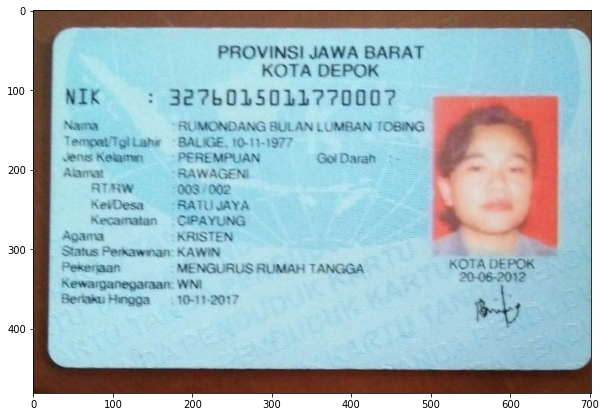

In [27]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.imread(processed_df[processed_df['file_name']=='KTP2'].iloc[0]['file_path'])[:, :, ::-1])

In [28]:
processed_df[processed_df['file_name']=='KTP2'].iloc[0]['text_cleaned']

'PROVINSI JAWA BARAT DEP 3276015011770007 NIK Nama RUMONDANG BULAN LUMBAN TOBING Tempat Tgl Lahir BALIGE 10-11-1977 Jenis Kelamin Alamat PEREMPUAN RAWAGENI 003 002 RATU JAYA CIPAYUNG KRISTEN Status Perkawinan KAWIN Gol Darah RTRW KeVDesa Kecamatan Agama RTU KART Pekerjaan MENGURUS RUMAH TANGGA KOTA DEPOK 20-06-2012 Kewarganegaraan WNI Berlaku Hingga 10-11-2017 ENDUDUKT ARTU TAN '

In [29]:
processed_df[processed_df['file_name']=='KTP2'].iloc[0]['tag']

'0 0 0 0 1 0 0 10 10 10 10 0 0 0 3 11 0 0 0 14 15 2 2 4 4 5 6 0 0 12 0 0 0 0 0 0 0 0 0 7 7 7 0 0 0 0 9 0 0 8 0 0 0 '

In [30]:
train, val, test = [], [], []
for i in zip(sentences, embeddings, tags):
    if i[2][1] == 1:
        val.append(i)
    elif i[2][2] == 1:
        test.append(i)
    else:
        train.append(i)

In [31]:
def dataset(data, max_len=75):
    embedding_dims = data[0][1][0].shape[0]
    embeddings = np.zeros((len(data), embedding_dims, max_len), dtype=np.float32)
    labels = np.zeros((len(data), max_len), dtype=int)
    for ind, item in enumerate(data):
        raw_embedding = item[1][0]
        raw_label = [int(i) for i in item[2][0].strip().split()]
        embeddings[ind, :, :raw_embedding.shape[1]] = raw_embedding[:, :max_len]
        labels[ind, :len(raw_label)] = np.array(raw_label)[:max_len]
    return np.transpose(embeddings, (0, 2, 1)), labels

X_train, Y_train = dataset(train)
X_val, Y_val = dataset(val)
X_test, Y_test = dataset(test)
print(f'Train data -> Data = {X_train.shape}   Labels = {Y_train.shape}\nVal data -> Data = {X_val.shape}   Labels = {Y_val.shape}\nTest data -> Data = {X_test.shape}   Labels = {Y_test.shape}')

Train data -> Data = (28, 75, 10)   Labels = (28, 75)
Val data -> Data = (10, 75, 10)   Labels = (10, 75)
Test data -> Data = (14, 75, 10)   Labels = (14, 75)


In [32]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [33]:
len(train_loader)

28

In [34]:
dataiter = iter(train_loader)
embeddings, labels = dataiter.next()
print('Model input => ', embeddings.size())
print('Embeddings =>\n', embeddings)
print('Model output => ', labels.size())
print('Labels =>\n', labels)

Model input =>  torch.Size([1, 75, 10])
Embeddings =>
 tensor([[[172.8000,  20.5714, 120.6857,  15.2381, 224.0000,   9.9048, 224.9143,
           26.6667, 121.6000,  32.0000],
         [283.4286,  16.0000, 226.7429,   9.9048, 339.2000,   4.5714, 340.1143,
           22.0952, 227.6572,  27.4286],
         [377.6000,  10.6667, 341.9429,   3.8095, 413.2571,   0.0000, 414.1714,
           17.5238, 342.8571,  21.3333],
         [234.0571,  33.5238, 205.7143,  27.4286, 261.4857,  24.3810, 262.4000,
           39.6190, 206.6286,  42.6667],
         [299.8857,  30.4762, 269.7143,  23.6190, 330.0571,  20.5714, 330.9714,
           38.0952, 270.6286,  41.1429],
         [ 22.8571,  69.3333,   0.0000,  60.1905,  43.8857,  57.9048,  45.7143,
           79.2381,   1.8286,  81.5238],
         [241.3714,  57.9048, 123.4286,  53.3333, 358.4000,  41.1429, 360.2286,
           62.4762, 125.2571,  74.6667],
         [241.3714,  57.9048, 123.4286,  53.3333, 358.4000,  41.1429, 360.2286,
           62.4762

In [35]:
class RNN(nn.Module):

    def __init__(self, output_dim, embedding_dim=10, hidden_dim=32, n_layers=1, drop_prob=0.25, batch_first=True, bidirectional=True):
        super().__init__()
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=batch_first, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return out

    
__model__ = RNN(output_dim=len(ind_to_label))
__model__

RNN(
  (lstm): LSTM(10, 32, batch_first=True, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=64, out_features=16, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [36]:
out = __model__(torch.randn((8, 75, 10)))
out.size()

torch.Size([8, 75, 16])

In [37]:
out = out.view(-1, out.shape[-1])
out.size()

torch.Size([600, 16])

In [38]:
class LitRNNModel(pl.LightningModule):

    def __init__(self, train_loader, val_loader, ce_weights, output_dim=16, batch_size=32, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(ce_weights).float())
        self.model = RNN(output_dim=output_dim)
        self.learning_rate=learning_rate
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.ce_weights = ce_weights
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x)
        y_hat = y_hat.view(-1, y_hat.shape[-1])
        y = y.view(-1)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def on_train_end(self, *args, **kwargs):
        self.logger.experiment.add_graph(LitRNNModel(self.train_loader, self.val_loader, ce_weights=self.ce_weights, output_dim=self.output_dim), torch.randn((8, 75, 10)))
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)
        y_hat = y_hat.view(-1, y_hat.shape[-1])
        y = y.view(-1)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self.forward(x)
        y_hat = y_hat.view(-1, y_hat.shape[-1])
        y = y.view(-1)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def configure_optimizers(self):
        steps_per_epoch = len(self.train_loader) // self.batch_size
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate, 
            betas=self.betas, 
            eps=self.eps, 
            weight_decay=self.weight_decay
        )
        cyclic_lr_scheduler = {
            "scheduler": CyclicLR(
                optimizer=optimizer,
                base_lr=self.learning_rate,
                max_lr=1e-6,
                cycle_momentum=False # False with AdamW
            ),
            "interval": "step"
        }
        return [optimizer], [cyclic_lr_scheduler]
    
    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        items.pop("loss", None)
        return items

/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at ../logs/lr_find_temp_model_06859de6-c479-432b-a208-acdffa511e3b.ckpt


CPU times: user 2.18 s, sys: 609 ms, total: 2.79 s
Wall time: 2.79 s


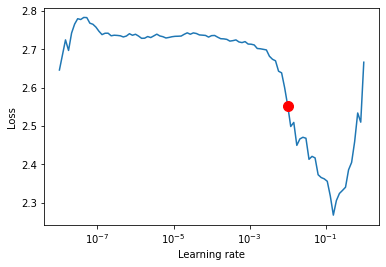

In [39]:
%%time
model = LitRNNModel(train_loader=train_loader, val_loader=val_loader, ce_weights=ce_weights, output_dim=len(ind_to_label), batch_size=32)
trainer = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, progress_bar_refresh_rate=0, default_root_dir='../logs')
lr_finder = trainer.tuner.lr_find(model)
fig = lr_finder.plot(suggest=True)
fig.show()

In [40]:
%%time
trainer = pl.Trainer(default_root_dir='../logs',
                       precision=32,
                       limit_train_batches=0.5,
                       gpus=1 if torch.cuda.is_available() else None, 
                       max_epochs=500,
                       logger=TensorBoardLogger('../logs', name='2022-01-06_combined_orc_kyc-rnns'),
                       callbacks=[
                              LearningRateMonitor(logging_interval="step"), 
                              ModelCheckpoint(monitor="train_loss"),
                          ]
                     )

trainer.fit(LitRNNModel(train_loader=train_loader, val_loader=val_loader, ce_weights=ce_weights, output_dim=len(ind_to_label)))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | RNN              | 12.3 K
-----------------------------------------------
12.3 K    Trainable params
0         Non-trainable params
12.3 K    Total params
0.049     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2022-02-10 18:22:42.571738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 18:22:42.571764: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 1min 40s, sys: 3.81 s, total: 1min 44s
Wall time: 1min 37s


/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)


In [41]:
%%time
trainer.test(ckpt_path="best", dataloaders=test_loader)

Restoring states from the checkpoint path at ../logs/2022-01-06_combined_orc_kyc-rnns/version_5/checkpoints/epoch=429-step=6019.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../logs/2022-01-06_combined_orc_kyc-rnns/version_5/checkpoints/epoch=429-step=6019.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.996155858039856}
--------------------------------------------------------------------------------
CPU times: user 73.3 ms, sys: 8.38 ms, total: 81.7 ms
Wall time: 79.4 ms


[{'test_loss': 0.996155858039856}]

In [43]:
%%time
res_model = LitRNNModel.load_from_checkpoint(checkpoint_path=trainer.checkpoint_callbacks[0].best_model_path, train_loader=train_loader, val_loader=val_loader, ce_weights=ce_weights, output_dim=len(ind_to_label))
res_model.eval()
trainer.test(res_model, dataloaders=train_loader)

/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6845568418502808}
--------------------------------------------------------------------------------
CPU times: user 112 ms, sys: 93 µs, total: 112 ms
Wall time: 110 ms


[{'test_loss': 0.6845568418502808}]

In [47]:
def inference(model, test_data, max_len=75):
    '''
        test_data: (Sentence, embeddings, labels)
    '''
    sentence, raw_embeddings, raw_labels = test_data
    torch.from_numpy(X_train), torch.from_numpy(Y_train)
    embeddings, label = dataset([test_data], max_len=max_len)
    embeddings, label = torch.from_numpy(embeddings), torch.from_numpy(label)
    out = model(embeddings)
    out = out.view(-1, out.shape[-1])
    label = label.view(-1)
    out, label = out.cpu().detach().numpy(), label.cpu().detach().numpy()
    out = np.argmax(out, axis=1)
    sentence = sentence[0]
    sentence_length = len(sentence.split())
    print('#' * 175)
    print(f'Sentence:\n{sentence}')
    true_tag, pred_tag = '', ''
    for i in label[:sentence_length]:
        true_tag += f'<{ind_to_label[str(i)].replace(" ", "-")}> '
    for i in out[:sentence_length]:
        pred_tag += f'<{ind_to_label[str(i)].replace(" ", "-")}> '
    print(f'\nTrue Tags:\n{true_tag.strip()}')
    print(f'\nPred Tags:\n{pred_tag.strip()}')
    print('#' * 175, '\n\n')
    
inference(res_model, train[0])

###############################################################################################################################################################################
Sentence:
PROVINSI KEPULAUAN RIAU 2171060103890002 NIK Nama KASTODI BATAM 01-03- 1089 LAKELAKI KOMPLEK RnKO BUKIT GOLF BLOKF NO 09 003 009 8UNGAIPANAS BATAM KOTA BUDHA KAWIN WIRASWASTA WNI SEUMUR HIDUP Twmpat Tol Lahir Jenis kefamin Alamat Gol Darah AT RW Kel Desa Kecamatan Agama Status Perkawinan Pekerjaan Kewarganegaraan Berlaku Hingga 23-07-2018 ARTUTAN 

True Tags:
<TEXT> <TEXT> <TEXT> <NIK> <TEXT> <TEXT> <RT/RW> <TEMPAT> <KEL/DESA> <KEL/DESA> <KECAMANTAN> <AGAMA> <AGAMA> <AGAMA> <AGAMA> <AGAMA> <AGAMA> <AGAMA> <PEKERJAAN> <PEKERJAAN> <BERLAKU-HINGGA> <KEWARGANEGARAAN> <KEWARGANEGARAAN> <NAMA> <TGL-LAHIR> <STATUS-PERKAWINAN> <KOTA> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT> <TEXT>

Pred Tags:
